In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
import statsmodels as sm

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Importing Special Features

In [2]:
df=pd.read_csv('recipeData.csv',encoding='latin1')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73861 entries, 0 to 73860
Data columns (total 23 columns):
BeerID           73861 non-null int64
Name             73860 non-null object
URL              73861 non-null object
Style            73265 non-null object
StyleID          73861 non-null int64
Size(L)          73861 non-null float64
OG               73861 non-null float64
FG               73861 non-null float64
ABV              73861 non-null float64
IBU              73861 non-null float64
Color            73861 non-null float64
BoilSize         73861 non-null float64
BoilTime         73861 non-null int64
BoilGravity      70871 non-null float64
Efficiency       73861 non-null float64
MashThickness    43997 non-null float64
SugarScale       73861 non-null object
BrewMethod       73861 non-null object
PitchRate        34609 non-null float64
PrimaryTemp      51199 non-null float64
PrimingMethod    6766 non-null object
PrimingAmount    4774 non-null object
UserId           23371 non

The data is 73861 rows long.
There are two columns, PrimingMethod & PrimingAmount, that has a lot of null values. To keep this going, I will be dropping these values, as well as the UserId

In [3]:

df = df.fillna(df.median())
df = df.drop('PrimingMethod',axis = 1)
df = df.drop('PrimingAmount', axis = 1)
df = df.drop('UserId',axis=1)
df = df.dropna()

#There is a lot of null values and this will allow me to remove all of the null values

In [4]:
df.SugarScale.value_counts() #understanding null values

Specific Gravity    71379
Plato                1885
Name: SugarScale, dtype: int64

In [5]:
df['Sugar'] = pd.get_dummies(df.SugarScale,drop_first=True)
brew_dummies= pd.get_dummies(df.BrewMethod)
df['All Grain'] = brew_dummies['All Grain']
df['BIAB'] = brew_dummies['BIAB']
df['Partial Mash'] = brew_dummies['Partial Mash']
df['extract'] = brew_dummies['extract'] #creating new coluns to account for Brewing Method
#Replacing them with new numeric values

In [6]:
df['IPA'] = np.where(df['Style'].str.contains('IPA'),1,0)
df['Stout'] = np.where(df['Style'].str.contains('Stout'),1,0)
df['Cider'] = np.where(df['Style'].str.contains('Cider'),1,0)
df['Lager'] = np.where(df['Style'].str.contains('Lager'),1,0)
df['Pilsner'] = np.where(df['Style'].str.contains('Pilsner'),1,0)
df['Wheat'] = np.where(df['Style'].str.contains('Wheat'),1,0) #creating new columns for the logistic regression
df1 = df.copy()
df2=df.copy() #new dataframe

In [7]:
df1.corr() #correlation

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
BeerID,1.000000,-0.073123,0.002055,-0.025490,-0.031332,-0.053099,-0.022177,-0.046157,0.002923,-0.045706,...,0.015167,0.047779,-0.051655,-0.042961,0.019168,-0.016712,-0.029159,0.113933,-0.012444,-0.021351
StyleID,-0.073123,1.000000,-0.006248,0.002742,0.007091,0.007434,-0.144485,0.167929,-0.005995,0.079929,...,0.013326,-0.000924,0.008074,-0.023730,-0.233578,0.165676,0.007649,-0.063548,0.014603,-0.093754
Size(L),0.002055,-0.006248,1.000000,0.161092,0.143493,-0.013559,-0.031297,-0.018027,0.994130,0.044319,...,0.091325,-0.057977,-0.027030,-0.048825,-0.005374,-0.007575,-0.007403,0.035159,0.001382,-0.003440
OG,-0.025490,0.002742,0.161092,1.000000,0.947101,0.030531,-0.001688,0.013867,0.163952,0.032138,...,0.074968,-0.042466,-0.023379,-0.045189,0.003578,0.015330,-0.005312,0.006278,-0.002754,-0.001726
FG,-0.031332,0.007091,0.143493,0.947101,1.000000,0.030034,-0.000198,0.031220,0.144821,0.032104,...,0.069878,-0.039998,-0.021417,-0.041891,-0.000854,0.032365,-0.006673,0.000970,-0.005523,-0.003880
ABV,-0.053099,0.007434,-0.013559,0.030531,0.030034,1.000000,0.282502,0.270414,-0.009858,0.120464,...,0.023404,-0.030472,0.009184,-0.005202,0.167061,0.139769,0.028381,-0.086966,-0.043755,-0.051378
IBU,-0.022177,-0.144485,-0.031297,-0.001688,-0.000198,0.282502,1.000000,0.062148,-0.029663,0.079896,...,0.001314,-0.006009,-0.002695,0.006773,0.428192,0.040853,-0.049445,-0.086535,-0.024519,-0.057219
Color,-0.046157,0.167929,-0.018027,0.013867,0.031220,0.270414,0.062148,1.000000,-0.016752,0.057795,...,0.006791,-0.010084,0.021703,-0.012658,-0.164103,0.653817,-0.024867,-0.089594,-0.073968,-0.088049
BoilSize,0.002923,-0.005995,0.994130,0.163952,0.144821,-0.009858,-0.029663,-0.016752,1.000000,0.050637,...,0.104054,-0.054719,-0.036471,-0.064919,-0.005126,-0.007322,-0.008656,0.034082,0.000176,-0.003629
BoilTime,-0.045706,0.079929,0.044319,0.032138,0.032104,0.120464,0.079896,0.057795,0.050637,1.000000,...,0.167687,-0.020642,-0.060780,-0.180957,-0.021791,0.028046,-0.118514,-0.013006,0.039083,-0.019940


There are no correlations with the different styles and exploratory values

In [9]:
from pandas.plotting import scatter_matrix
scatter_matrix(df1);

In [10]:
df.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1,0,0,0,0,0,0,0,0,0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1,0,0,0,0,0,0,0,0,0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,0,0,0,1,1,0,0,0,0,0
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,1,0,0,0,1,0,0,0,0,0
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,1,0,0,0,0,0,0,0,0,0


In [11]:
df1.dtypes #Understanding what is going on

BeerID             int64
Name              object
URL               object
Style             object
StyleID            int64
Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PitchRate        float64
PrimaryTemp      float64
Sugar              uint8
All Grain          uint8
BIAB               uint8
Partial Mash       uint8
extract            uint8
IPA                int64
Stout              int64
Cider              int64
Lager              int64
Pilsner            int64
Wheat              int64
dtype: object

In [12]:
lrg = LogisticRegression() #Importing Logistic Regression

In [13]:
df1['Other'] = df1.IPA+df1.Stout+df1.Cider+df1.Lager+df1.Pilsner+df1.Wheat 

In [14]:
df5=df1[df1['Other']==1] #removing all of the columns that did not fall under the original categories

In [15]:
df5.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat,Other
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,0,0,1,1,0,0,0,0,0,1
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,0,0,0,1,0,0,0,0,0,1
6,7,Russian River Pliny the Elder (original),/homebrew/recipe/view/37534/russian-river-plin...,Imperial IPA,86,22.71,1.072,1.018,7.09,268.71,...,0,0,0,1,0,0,0,0,0,1
9,10,Mango Habanero IPA,/homebrew/recipe/view/61082/mango-habanero-ipa,Imperial IPA,86,20.82,1.080,1.017,8.22,93.02,...,0,0,0,1,0,0,0,0,0,1
10,11,Bakke Brygg HveteIPA 25 L,/homebrew/recipe/view/73890/bakke-brygg-hvetei...,American IPA,7,25.00,1.064,1.014,6.63,64.26,...,0,0,0,1,0,0,0,0,0,1


In [16]:
scaler = StandardScaler() #importing Standard Scaler to help normalize the data

In [17]:
import statsmodels.api as sm
from scipy import stats

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## IPA

In [18]:
X1 = df5.drop('StyleID',axis=1)
X1 = X1.drop('Style',axis=1)
X1= X1.drop('Name',axis=1)
X1= X1.drop('URL',axis=1)
X1 = X1.drop('BeerID',axis=1)
X1 = X1.drop('SugarScale',axis=1)
X1 = X1.drop('BrewMethod',axis = 1)
X1 = X1.drop('IPA',axis=1)
X1 = X1.drop('Wheat',axis=1)
X1 = X1.drop('Stout',axis=1)
X1 = X1.drop('Cider',axis=1)
X1 = X1.drop('Lager',axis=1)
X1 = X1.drop('Pilsner',axis=1)
X1 = X1.drop('Other',axis=1)
y1 = df5.IPA

lrg.fit(X1,y1) #preparing the IPA data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
(sum(df5.IPA))/len(df5) #determining the amount percentage of IPA in the dataframe

0.5832251008271242

In [20]:
lrg.score(X1,y1)

0.84927199398455122

In [21]:
X2 = X1 #selecting a column to use to categorize the data

In [22]:
lrg.fit(X2,y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
lrg.score(X2,y1)

0.84927199398455122

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X2,y1)

In [25]:
X_train_scaler = scaler.fit_transform(X_train)

In [26]:
X_test_scaler = scaler.fit_transform(X_test)

In [27]:
lrg.fit(X_train_scaler,y_train)
lrg.score(X_train_scaler,y_train)

0.84819760288018953

In [28]:
lrg.fit(X_test_scaler,y_test)
lrg.score(X_test_scaler,y_test)

0.85413533834586464

In [29]:
ipa_pred = lrg.predict(X_test_scaler) #Developing predicting

In [30]:
lrg.coef_

array([[ -3.48124191e-02,  -1.11791348e-01,   2.04559598e-02,
          2.88366723e-01,   2.73271057e+00,  -1.75646578e+00,
          1.35538237e-02,  -1.19929139e-01,   6.86570338e-02,
          1.16986463e-02,   1.69958306e-02,  -4.00881119e-01,
          4.50622464e-01,  -2.13984118e-03,   7.55625531e-02,
          1.53885245e-02,   4.18715706e-03,  -1.28612488e-01]])

In [31]:
print(confusion_matrix(y_test,ipa_pred))

[[2384  638]
 [ 429 3864]]


In [32]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [33]:
grid = GridSearchCV(lrg,param_grid,scoring='precision')

In [34]:
grid.fit(X_train_scaler,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [35]:
grid.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
best = grid.best_estimator_ #finding the best estimator for the IPA project

In [37]:
best.fit(X_train_scaler,y_train)
best.score(X_train_scaler,y_train)

0.84819760288018953

In [38]:
best.fit(X_test,y_test)
best.score(X_test,y_test)

0.85345181134654824

In [39]:
best.coef_

array([[ -3.43113455e-04,  -1.33846176e-01,   2.00300869e-01,
          1.56618852e-01,   5.46025624e-02,  -1.22442384e-01,
          2.09763527e-04,  -8.45273196e-03,   2.63983591e-02,
          7.88319802e-04,   1.19984795e-02,  -1.46036810e+00,
          1.33068467e-01,  -9.40869275e-01,  -1.70125625e-01,
         -2.88487567e-01,  -3.10779590e-01,  -7.19978786e-01]])

In [40]:
X2.columns


Index(['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',
       'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate',
       'PrimaryTemp', 'Sugar', 'All Grain', 'BIAB', 'Partial Mash', 'extract'],
      dtype='object')

In [41]:
pred_best_ipa = best.predict(X_test)

In [42]:
print(confusion_matrix(y_test,pred_best_ipa))

[[2381  641]
 [ 431 3862]]


In [43]:
3862/len(X_test)

0.5279562542720437

## Stout

In [44]:
X3 = df5
X3 = df5.drop('StyleID',axis=1)
X3 = X3.drop('Style',axis=1)
X3= X3.drop('Name',axis=1)
X3= X3.drop('URL',axis=1)
X3 = X3.drop('BeerID',axis=1)
X3 = X3.drop('SugarScale',axis=1)
X3 = X3.drop('BrewMethod',axis = 1)
X3 = X3.drop('Stout',axis=1)
X3 = X3.drop('IPA',axis=1)
X3 = X3.drop('Wheat',axis=1)
X3 = X3.drop('Cider',axis=1)
X3 = X3.drop('Lager',axis=1)
X3 = X3.drop('Pilsner',axis=1)
X3 = X3.drop('Other',axis=1)

y2=df5.Stout
X3 = X3

In [45]:
lrg.fit(X3,y2)
lrg.score(X3,y2)

0.95478159819536534

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X3,y2)

In [47]:
X_train_scaler = scaler.fit_transform(X_train) #normalizing the training set

In [48]:
X_test_scaler = scaler.fit_transform(X_test) #normalizing the test set

In [49]:
lrg.fit(X_train_scaler,y_train)
lrg.score(X_train_scaler,y_train)

0.95584013124914546

In [50]:
lrg.fit(X_test_scaler,y_test)
lrg.score(X_test_scaler,y_test)

0.94873547505126454

In [51]:
lrg.coef_

array([[ 0.08495609, -0.78550666,  0.59428415, -0.34628495, -0.53276104,
         3.04154854, -0.07877788,  0.20930229,  0.16276012,  0.19274639,
        -0.00996594, -0.0429833 ,  0.02629415, -0.10542006, -0.10886491,
        -0.04407596,  0.02653217,  0.18924479]])

The color of the Stout seems to be the key indicator with a coeficient of 3.08

In [52]:
test_pred = lrg.predict(X_test_scaler)

In [53]:
print(confusion_matrix(y_test,test_pred))

[[5615  233]
 [ 142 1325]]


In [54]:
grid.fit(X_test_scaler,y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [55]:
pred_test = grid.predict(X_test_scaler)

In [56]:
print(confusion_matrix(y_test,pred_test))

[[5615  233]
 [ 142 1325]]


In [57]:
(sum(df5.Stout))/len(df5)

0.20349989746394148

In [58]:
1363/7315 #this time with my stout identification was only off by 1%

0.18632946001367054

## Minimizing the Subset

In [59]:
df5['Other_x'] = df5.Cider+df5.Lager+df5.Wheat+df5.Pilsner #due the large number of IPAs, I developed a subet to remove IPA & Stout since it was originally skewing results 

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
df6 = df5[df5.Other_x >0]
df6 = df6.drop('Other_x',axis=1)

## Cider

In [61]:
X4 = df6
X4 = df6.drop('StyleID',axis=1)
X4 = X4.drop('Style',axis=1)
X4= X4.drop('Name',axis=1)
X4= X4.drop('URL',axis=1)
X4 = X4.drop('BeerID',axis=1)
X4 = X4.drop('SugarScale',axis=1)
X4 = X4.drop('BrewMethod',axis = 1)
X4 = X4.drop('Stout',axis=1)
X4 = X4.drop('IPA',axis=1)
X4 = X4.drop('Wheat',axis=1)
X4 = X4.drop('Cider',axis=1)
X4 = X4.drop('Lager',axis=1)
X4 = X4.drop('Pilsner',axis=1)
X4=X4

y3=df6.Cider

In [62]:
rand = RandomForestClassifier(max_depth=5)

In [63]:
rand.fit(X4,y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
rand.score(X4,y3)

0.98317307692307687

In [65]:
rand.feature_importances_

array([ 0.03694458,  0.02816888,  0.10267459,  0.05376682,  0.11005916,
        0.06591945,  0.06881814,  0.29865708,  0.03365945,  0.09000458,
        0.00707705,  0.04114969,  0.04005008,  0.        ,  0.00398673,
        0.00172598,  0.00262923,  0.0147085 ,  0.        ])

In [66]:
cider_feats = rand.feature_importances_

In [67]:
cider_feats

array([ 0.03694458,  0.02816888,  0.10267459,  0.05376682,  0.11005916,
        0.06591945,  0.06881814,  0.29865708,  0.03365945,  0.09000458,
        0.00707705,  0.04114969,  0.04005008,  0.        ,  0.00398673,
        0.00172598,  0.00262923,  0.0147085 ,  0.        ])

In [68]:
X4.columns 

Index(['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',
       'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate',
       'PrimaryTemp', 'Sugar', 'All Grain', 'BIAB', 'Partial Mash', 'extract',
       'Other'],
      dtype='object')

It appears within Cider, the most important feature is the IBU, which is different from what was expected. Throughout most of the test, it seemed that Color was the main indicator

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X4,y3)

In [70]:
scaler_test = scaler.fit_transform(X_test)

In [71]:
rand.fit(scaler_test,y_test)
pred_test = rand.predict(scaler_test)

In [72]:
param_tree = {'max_depth': np.arange(1,15),'min_samples_leaf':np.arange(1,5)}

In [73]:
grid_cider = GridSearchCV(rand,param_tree)

In [74]:
grid_cider.fit(scaler_test,y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
best_cider = grid_cider.best_estimator_

In [76]:
best_cider.fit(scaler_test,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
best_cider.feature_importances_

array([ 0.05327617,  0.06939482,  0.09235041,  0.11258263,  0.07026539,
        0.08480878,  0.09798904,  0.1912647 ,  0.0728924 ,  0.06377841,
        0.01246459,  0.0070374 ,  0.03487222,  0.00307796,  0.01052782,
        0.01247737,  0.00207521,  0.00886469,  0.        ])

In [78]:
pred_test = best_cider.predict(scaler_test)

In [79]:
print(confusion_matrix(y_test,pred_test))

[[1515    0]
 [   7   38]]


In [80]:
len(X_test)

1560

In [81]:
36/1560

0.023076923076923078

In [82]:
(sum(df6.Cider))/len(df6)

0.030608974358974358

## Wheat

In [166]:
X5 = df6
X5 = df6.drop('StyleID',axis=1)
X5 = X5.drop('Style',axis=1)
X5= X5.drop('Name',axis=1)
X5= X5.drop('URL',axis=1)
X5 = X5.drop('BeerID',axis=1)
X5 = X5.drop('SugarScale',axis=1)
X5 = X5.drop('BrewMethod',axis = 1)
X5 = X5.drop('Stout',axis=1)
X5 = X5.drop('IPA',axis=1)
X5 = X5.drop('Wheat',axis=1)
X5 = X5.drop('Cider',axis=1)
X5 = X5.drop('Lager',axis=1)
X5 = X5.drop('Pilsner',axis=1)
X5 = X5.drop('Other', axis=1)

y4=df6.Wheat

In [167]:
rand.fit(X5,y4)
rand.score(X5,y4)

0.79711538461538467

In [168]:
rand.feature_importances_

array([  3.69584601e-02,   3.16441367e-02,   1.57458688e-02,
         6.70291438e-02,   1.36630115e-01,   1.68697837e-01,
         1.44717464e-02,   1.15839531e-02,   4.32790407e-02,
         8.37797320e-03,   4.62622148e-02,   1.46454123e-01,
         2.67754096e-01,   9.40973971e-05,   3.60937564e-03,
         2.64369965e-04,   6.75136345e-04,   4.68312381e-04])

In [169]:
X5.columns

Index(['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',
       'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate',
       'PrimaryTemp', 'Sugar', 'All Grain', 'BIAB', 'Partial Mash', 'extract'],
      dtype='object')

In [170]:
X_train,X_test,y_train,y_test = train_test_split(X5,y4)

In [171]:
scaler_train = scaler.fit_transform(X_train)
scaler_test = scaler.fit_transform(X_test)

In [172]:
rand.fit(scaler_test,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [173]:
rand.score(scaler_test,y_test)

0.8224358974358974

In [174]:
pred_wheat = rand.predict(scaler_test)

In [175]:
#print(confusion_matrix(y_test,pred_wheat))

In [176]:
(sum(df6.Wheat))/len(df6)

0.20288461538461539

In [177]:
#53/1560

In [178]:
param_tree = {'max_depth': np.arange(1,15),'min_samples_leaf':np.arange(1,5)}

In [179]:
grid_wheat = GridSearchCV(rand,param_tree)

In [180]:
grid_wheat.fit(scaler_test,y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [181]:
best_wheat = grid_wheat.best_estimator_

In [182]:
best_wheat.fit(scaler_test,y_test)
best_wheat_pred = best_wheat.predict(scaler_test)

In [183]:
print(confusion_matrix(y_test,best_wheat_pred))

[[1251   18]
 [ 134  157]]


In [184]:
304/1560

0.19487179487179487

In [185]:
best_wheat.feature_importances_

array([  3.96057104e-02,   5.66373786e-02,   3.68036748e-02,
         1.04750748e-01,   1.31944523e-01,   1.71529775e-01,
         4.79643533e-02,   6.49548973e-03,   5.90387974e-02,
         2.53417074e-02,   4.47203912e-02,   8.92748064e-02,
         1.66862664e-01,   0.00000000e+00,   9.32456783e-03,
         2.68666720e-03,   1.53705393e-04,   6.86503993e-03])

After tuning the algorithm, it appears that Color is the most important feature within wheat beer

## Lager

In [103]:
X6 = df6
X6 = df6.drop('StyleID',axis=1)
X6 = X6.drop('Style',axis=1)
X6 = X6.drop('Name',axis=1)
X6= X6.drop('URL',axis=1)
X6 = X6.drop('BeerID',axis=1)
X6 = X6.drop('SugarScale',axis=1)
X6 = X6.drop('BrewMethod',axis = 1)
X6 = X6.drop('Stout',axis=1)
X6 = X6.drop('IPA',axis=1)
X6 = X6.drop('Wheat',axis=1)
X6 = X6.drop('Cider',axis=1)
X6 = X6.drop('Lager',axis=1)
X6 = X6.drop('Pilsner',axis=1)

y5=df6.Lager

In [104]:
X_train,X_test,y_train,y_test = train_test_split(X6,y5)

In [105]:
scaler_test = scaler.fit_transform(X_test)
scaler_train = scaler.fit_transform(X_train)

In [106]:
rand.fit(scaler_train,y_train)
rand.score(scaler_train,y_train)

0.72756410256410253

In [107]:
grid.fit(scaler_train,y_train)
grid.fit(scaler_test,y_test)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [108]:
best_test_lager = grid.best_estimator_


In [109]:
best_test_lager.fit(scaler_test,y_test)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
pred_lager = best_test_lager.predict(scaler_test)

In [111]:
print(confusion_matrix(y_test,pred_lager))

[[157 397]
 [129 877]]


In [112]:
(sum(df6.Lager))/len(df6)

0.6586538461538461

In [113]:
977/1560

0.6262820512820513

In [114]:
rand.feature_importances_

array([ 0.01869433,  0.06919043,  0.01300588,  0.11418876,  0.06189133,
        0.31703329,  0.02105285,  0.0561907 ,  0.01547182,  0.01961246,
        0.07027712,  0.11063672,  0.1081389 ,  0.00048054,  0.        ,
        0.        ,  0.00262071,  0.00151417,  0.        ])

In [115]:
lag_feat = rand.feature_importances_

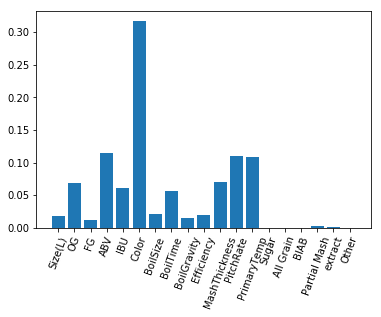

In [116]:
plt.figure()
plt.bar(range(len(lag_feat)), lag_feat)
plt.xticks(range(len(lag_feat)), X6.columns, rotation = 70); #visualizing feature importance

## Pilsner

In [150]:
X7 = df6
X7 = df6.drop('StyleID',axis=1)
X7 = X7.drop('Style',axis=1)
X7 = X7.drop('Name',axis=1)
X7= X7.drop('URL',axis=1)
X7 = X7.drop('BeerID',axis=1)
X7 = X7.drop('SugarScale',axis=1)
X7 = X7.drop('BrewMethod',axis = 1)
X7 = X7.drop('Stout',axis=1)
X7 = X7.drop('IPA',axis=1)
X7 = X7.drop('Wheat',axis=1)
X7 = X7.drop('Cider',axis=1)
X7 = X7.drop('Lager',axis=1)
X7 = X7.drop('Pilsner',axis=1)

y6=df6.Pilsner

In [151]:
X_train,X_test,y_train,y_test = train_test_split(X7,y6)

In [152]:
scaler_train = scaler.fit_transform(X_train)
scaler_test = scaler.fit_transform(X_test)

In [153]:
rand.fit(scaler_test,y_test)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [154]:
grid.fit(scaler_test,y_test)

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [155]:
best_test_pils = grid.best_estimator_

In [156]:
best_test_pils.fit(scaler_test,y_test)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [157]:
pred_pils = best_test_pils.predict(scaler_test)

In [158]:
print(confusion_matrix(y_test,pred_pils))

[[1370    5]
 [ 177    8]]


In [159]:
983/1560

0.6301282051282051

In [160]:
(sum(df6.Pilsner))/len(df6)

0.10785256410256411

In [161]:
6/1560

0.0038461538461538464

In [162]:
pilsn_feature = rand.feature_importances_

In [163]:
pilsn_feature

array([ 0.04793005,  0.04935915,  0.01690114,  0.05426208,  0.09045253,
        0.22759534,  0.07081684,  0.09550269,  0.04183557,  0.04172549,
        0.03765248,  0.045012  ,  0.16780869,  0.00051672,  0.00615174,
        0.0064775 ,  0.        ,  0.        ,  0.        ])

In [164]:
X7.columns

Index(['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',
       'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate',
       'PrimaryTemp', 'Sugar', 'All Grain', 'BIAB', 'Partial Mash', 'extract',
       'Other'],
      dtype='object')

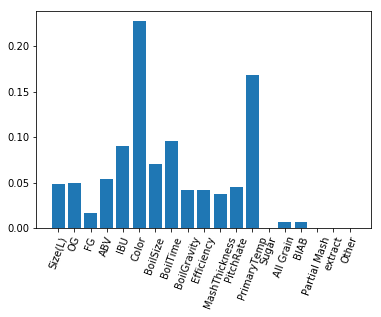

In [165]:
plt.figure()
plt.bar(range(len(pilsn_feature)), pilsn_feature)
plt.xticks(range(len(pilsn_feature)), X7.columns, rotation = 70); #visualizing feature importance

## Color Breakdown

In [133]:
ipa = df[df['Style'].str.contains('IPA')]

In [134]:
ipa.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,0,0,0,1,1,0,0,0,0,0
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,1,0,0,0,1,0,0,0,0,0
6,7,Russian River Pliny the Elder (original),/homebrew/recipe/view/37534/russian-river-plin...,Imperial IPA,86,22.71,1.072,1.018,7.09,268.71,...,1,0,0,0,1,0,0,0,0,0
9,10,Mango Habanero IPA,/homebrew/recipe/view/61082/mango-habanero-ipa,Imperial IPA,86,20.82,1.080,1.017,8.22,93.02,...,1,0,0,0,1,0,0,0,0,0
10,11,Bakke Brygg HveteIPA 25 L,/homebrew/recipe/view/73890/bakke-brygg-hvetei...,American IPA,7,25.00,1.064,1.014,6.63,64.26,...,1,0,0,0,1,0,0,0,0,0


In [135]:
stout = df[df['Style'].str.contains('Stout')]
pilsner = df[df['Style'].str.contains('Pilsner')]
wheat =df[df['Style'].str.contains('Wheat')]
lager =df[df['Style'].str.contains('Lager')]
cider =df[df['Style'].str.contains('Cider')]

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


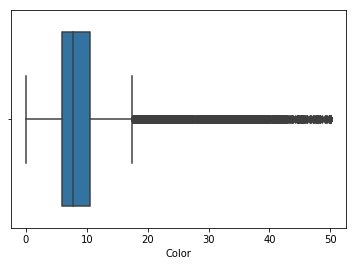

In [136]:
plt.figure()

sns.boxplot(x=ipa.Color)

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


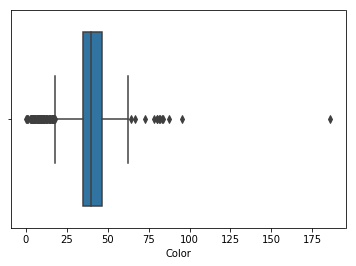

In [137]:
plt.figure()

sns.boxplot(x=stout.Color)

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


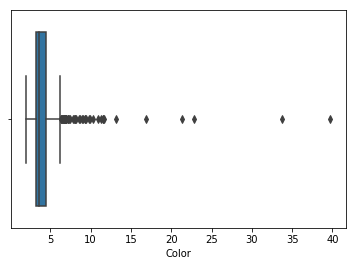

In [138]:
plt.figure()

sns.boxplot(x=pilsner.Color)

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


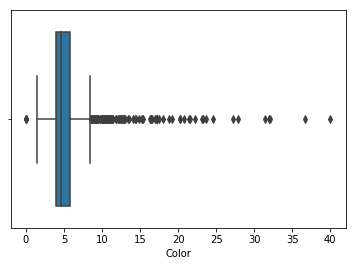

In [139]:
plt.figure()

sns.boxplot(x=wheat.Color)

In [140]:
wheat.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,...,1266.000000,1266.000000,1266.000000,1266.000000,1266.0,1266.0,1266.0,1266.0,1266.0,1266.0
mean,33554.004739,19.567930,39.310205,1.377728,1.063219,5.412441,26.427741,5.478934,44.510687,62.839652,...,0.637441,0.158768,0.050553,0.153239,0.0,0.0,0.0,0.0,0.0,1.0
std,20542.057129,27.902238,144.476555,2.057059,0.389480,1.192862,15.862430,3.410113,154.054077,10.927951,...,0.480929,0.365604,0.219169,0.360360,0.0,0.0,0.0,0.0,0.0,0.0
min,112.000000,14.000000,2.840000,1.000000,1.000000,0.000000,0.000000,0.000000,3.790000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
25%,15774.250000,14.000000,18.930000,1.048000,1.010000,4.830000,18.622500,3.890000,18.170000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
50%,32279.500000,14.000000,20.820000,1.051000,1.012000,5.240000,23.940000,4.575000,26.500000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
75%,51012.750000,15.000000,22.710000,1.056000,1.014000,5.647500,30.780000,5.730000,28.390000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
max,73494.000000,172.000000,2346.960000,29.586800,9.861370,12.800000,176.950000,40.000000,2405.630000,120.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0


/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


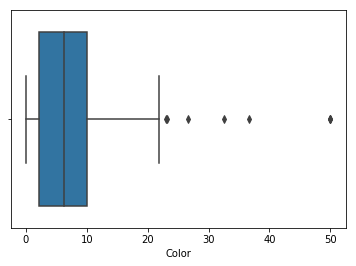

In [141]:
plt.figure()

sns.boxplot(x=cider.Color)

In [142]:
cider.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,191.000000,191.0,191.0,191.0,191.0,191.0,191.0
mean,24831.125654,68.272251,17.855131,1.177976,1.020140,7.178796,4.141832,7.598901,17.071571,30.298429,...,0.356021,0.094241,0.062827,0.486911,0.0,0.0,1.0,0.0,0.0,0.0
std,22079.512557,29.772810,11.203763,1.099105,0.109689,4.861077,27.449667,8.215034,14.513478,28.697147,...,0.480080,0.292931,0.243290,0.501142,0.0,0.0,0.0,0.0,0.0,0.0
min,223.000000,44.000000,3.790000,1.000000,0.998000,0.010000,0.000000,0.000000,1.890000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
25%,7992.500000,44.000000,9.500000,1.048000,1.004500,5.155000,0.000000,2.160000,7.570000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
50%,16269.000000,64.000000,18.930000,1.057000,1.010000,6.380000,0.000000,6.210000,15.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
75%,39129.500000,76.000000,20.820000,1.068000,1.015000,7.670000,0.000000,10.035000,22.710000,60.000000,...,1.000000,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0
max,73529.000000,121.000000,75.000000,12.583000,2.492320,42.030000,369.990000,50.000000,120.000000,90.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0


/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


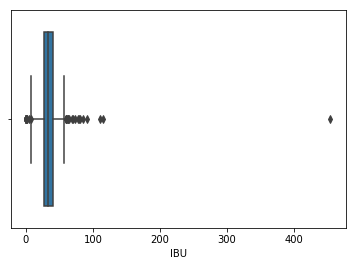

In [143]:
plt.figure()

sns.boxplot(x=pilsner.IBU)

/Users/paulszewczyk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


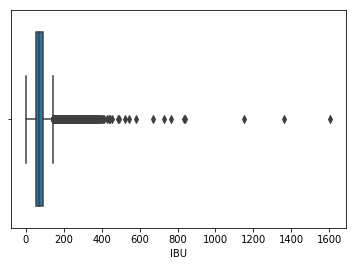

In [144]:
plt.figure()

sns.boxplot(x=ipa.IBU)

In [145]:
ipa.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,17064.000000,17064.000000,17064.000000,17064.000000,17064.000000,17064.000000,17064.000000,17064.000000,17064.000000,17064.000000,...,17064.000000,17064.000000,17064.000000,17064.000000,17064.0,17064.0,17064.0,17064.0,17064.0,17064.0
mean,37726.690811,35.665319,42.233233,1.420608,1.075007,6.706668,76.712765,9.849520,48.002246,64.503340,...,0.678270,0.159400,0.045241,0.117089,1.0,0.0,0.0,0.0,0.0,0.0
std,21348.478402,48.690276,166.951195,2.280309,0.407044,1.397430,50.072863,7.356278,176.639266,12.334497,...,0.467154,0.366059,0.207839,0.321535,0.0,0.0,0.0,0.0,0.0,0.0
min,3.000000,7.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
25%,19191.500000,7.000000,18.930000,1.059000,1.012000,5.960000,52.507500,5.950000,22.710000,60.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
50%,38366.500000,7.000000,20.820000,1.065000,1.014000,6.580000,67.205000,7.710000,28.000000,60.000000,...,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
75%,56130.750000,56.000000,23.092500,1.073000,1.017000,7.350000,88.740000,10.562500,30.000000,60.000000,...,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
max,73861.000000,152.000000,5850.000000,24.902800,6.886390,50.860000,1605.830000,50.000000,5850.000000,210.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0


In [146]:
stout.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,5954.000000,...,5954.000000,5954.000000,5954.000000,5954.000000,5954.0,5954.0,5954.0,5954.0,5954.0,5954.0
mean,35787.867316,91.438025,39.396006,1.519629,1.121958,7.019174,50.096181,39.641817,45.041221,66.512597,...,0.665603,0.161404,0.055425,0.117568,0.0,1.0,0.0,0.0,0.0,0.0
std,21780.618053,50.958239,162.074835,2.786090,0.678523,2.474264,54.602006,8.547443,173.289049,16.463682,...,0.471819,0.367934,0.228827,0.322123,0.0,0.0,0.0,0.0,0.0,0.0
min,47.000000,12.000000,1.890000,1.000000,1.000000,0.140000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
25%,16552.500000,58.000000,18.930000,1.056000,1.014000,5.310000,31.480000,34.960000,18.947500,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
50%,34929.000000,93.000000,20.820000,1.067000,1.018000,6.350000,41.970000,39.740000,26.500000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
75%,54591.250000,132.000000,22.710000,1.088000,1.022000,8.400000,63.187500,46.497500,28.500000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
max,73831.000000,166.000000,3637.780000,32.500800,10.341400,52.160000,3409.300000,186.000000,3785.410000,240.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0


In [147]:
pilsner.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,...,673.000000,673.000000,673.000000,673.000000,673.0,673.0,673.0,673.0,673.0,673.0
mean,34231.277860,68.389302,46.583952,1.343478,1.051265,5.286939,33.786256,4.235260,50.152927,71.190193,...,0.710253,0.150074,0.050520,0.089153,0.0,0.0,0.0,0.0,1.0,0.0
std,21083.220767,18.935197,164.328126,1.821202,0.270018,0.852906,20.633869,2.518713,164.631234,15.374185,...,0.453982,0.357410,0.219178,0.285176,0.0,0.0,0.0,0.0,0.0,0.0
min,45.000000,40.000000,3.790000,1.024000,1.003000,2.520000,0.000000,1.970000,1.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
25%,17078.000000,40.000000,19.870000,1.047000,1.009000,4.820000,26.990000,3.220000,22.710000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
50%,32505.000000,81.000000,20.820000,1.050000,1.011000,5.140000,33.080000,3.650000,28.390000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
75%,51330.000000,81.000000,25.550000,1.055000,1.014000,5.600000,39.820000,4.420000,32.180000,90.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
max,73630.000000,81.000000,2200.000000,14.499200,3.909490,10.380000,453.900000,39.740000,2200.000000,120.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0


In [148]:
wheat.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,...,1266.000000,1266.000000,1266.000000,1266.000000,1266.0,1266.0,1266.0,1266.0,1266.0,1266.0
mean,33554.004739,19.567930,39.310205,1.377728,1.063219,5.412441,26.427741,5.478934,44.510687,62.839652,...,0.637441,0.158768,0.050553,0.153239,0.0,0.0,0.0,0.0,0.0,1.0
std,20542.057129,27.902238,144.476555,2.057059,0.389480,1.192862,15.862430,3.410113,154.054077,10.927951,...,0.480929,0.365604,0.219169,0.360360,0.0,0.0,0.0,0.0,0.0,0.0
min,112.000000,14.000000,2.840000,1.000000,1.000000,0.000000,0.000000,0.000000,3.790000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
25%,15774.250000,14.000000,18.930000,1.048000,1.010000,4.830000,18.622500,3.890000,18.170000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
50%,32279.500000,14.000000,20.820000,1.051000,1.012000,5.240000,23.940000,4.575000,26.500000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
75%,51012.750000,15.000000,22.710000,1.056000,1.014000,5.647500,30.780000,5.730000,28.390000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
max,73494.000000,172.000000,2346.960000,29.586800,9.861370,12.800000,176.950000,40.000000,2405.630000,120.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.0


In [149]:
lager.describe()

,BeerID,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,...,All Grain,BIAB,Partial Mash,extract,IPA,Stout,Cider,Lager,Pilsner,Wheat
count,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,...,4110.000000,4110.000000,4110.000000,4110.000000,4110.0,4110.0,4110.0,4110.0,4110.0,4110.0
mean,46944.824818,44.945742,70.027399,1.462944,1.077360,5.470027,29.612474,9.017710,76.825725,64.296107,...,0.678832,0.161557,0.036496,0.123114,0.0,0.0,0.0,1.0,0.0,0.0
std,19834.175089,53.251423,295.028539,2.237428,0.392781,2.042632,30.766238,9.365171,311.414630,14.762636,...,0.466982,0.368089,0.187544,0.328608,0.0,0.0,0.0,0.0,0.0,0.0
min,31.000000,8.000000,1.000000,1.000000,0.742709,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
25%,33433.250000,9.000000,18.930000,1.047000,1.009000,4.710000,14.032500,3.700000,21.000000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
50%,50572.500000,9.000000,20.820000,1.052000,1.012000,5.245000,25.280000,5.460000,28.390000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
75%,63545.250000,88.000000,25.000000,1.060000,1.015000,5.960000,37.570000,10.562500,30.280000,60.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
max,73849.000000,167.000000,7800.000000,23.431600,7.745770,53.810000,920.050000,50.000000,7800.000000,240.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0


While color was the main indicator amongst 4 of the 6, other important features displayed was the PitchRate and the Sugar used for the beer as well.

For future experiments I would like to examine what separates the styles of the IPAs. Does each unique IPA have a unique feature or do they all have the same unique feature altered.